## Key concepts
1. Tool Creation: Use the @tool decorator to create a tool. A tool is an association between a function and its schema.

2. Tool Binding: The tool needs to be connected to a model that supports tool calling. This gives the model awareness of the tool and the associated input schema required by the tool.

3. Tool Calling: When appropriate, the model can decide to call a tool and ensure its response conforms to the tool's input schema.

4. Tool Execution: The tool can be executed using the arguments provided by the model.

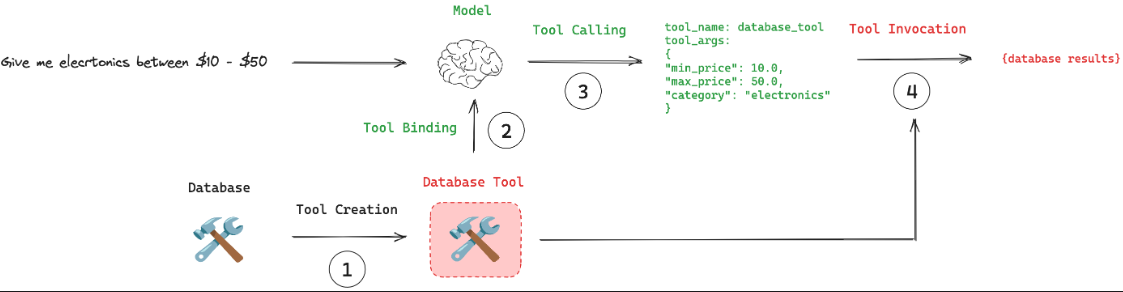

### Tool Binding 
 tool binding, which is the first technical step in integrating tools with LLMs. Tool binding involves:

Registering tools with the LLM so that it knows which tools are available.
Providing each tool’s name, description, and expected input format (input schema) to the LLM.
Enabling the LLM to understand how to invoke the tool correctly.

In [3]:
import os 
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
import requests

In [2]:
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="deepseek-r1-distill-llama-70b")
llm.invoke("Hello, how are you?")

AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.175412109, 'prompt_time': 0.009779293, 'queue_time': 0.051184097, 'total_time': 0.185191402}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--df11ce6b-d897-4121-a2fd-c5be3ed32ebe-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})

In [3]:
# tool create

@tool
def multiply(a: int, b: int) -> int:
  """Given 2 numbers a and b this tool returns their product"""
  return a * b
print(multiply.invoke({'a':3, 'b':4}))

12


In [4]:
llm_with_tools = llm.bind_tools([multiply])

In [ ]:
result = llm_with_tools.invoke("What is 2 multiplied by 3?")

In [ ]:
result

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking, "What is 2 multiplied by 3?" I need to figure out the best way to help them. Since I have a tool called "multiply" that takes two integers and returns their product, that seems perfect for this task. \n\nFirst, I should identify the function name, which is "multiply". Then, I need to determine the arguments. The numbers given are 2 and 3, so I\'ll assign a as 2 and b as 3. \n\nI should make sure that the JSON structure is correct. The function name should be a string, and the arguments should be a JSON object with the parameters a and b as integers. \n\nPutting it all together, the tool call should look like this: {"name": "multiply", "arguments": {"a": 2, "b": 3}}. This should give the correct result when processed.\n', 'tool_calls': [{'id': 'jf1fxq6nb', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21

In [ ]:
result.tool_calls

NameError: name 'result' is not defined

## Tool calling
A key principle of tool calling is that the model decides when to use a tool based on the input's relevance. The model doesn't always need to call a tool
![image.png](attachment:image.png)


In [ ]:
tool_result

ToolMessage(content='6', name='multiply', tool_call_id='jf1fxq6nb')

In [ ]:
tool_result = multiply.invoke(result.tool_calls[0])

NameError: name 'multiply' is not defined

## Dynamically select tools
Configure tool availability at runtime based on context:

In [ ]:
from dataclasses import dataclass
from typing import Literal

from langchain_core.tools import tool

from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt.chat_agent_executor import AgentState
from langgraph.runtime import Runtime


d:\Tranining_Code\AI_builder_Program_New\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@dataclass
class CustomContext:
    tools: list[Literal["weather", "compass"]]


@tool
def weather() -> str:
    """Returns the current weather conditions."""
    return "It's nice and sunny."


@tool
def compass() -> str:
    """Returns the direction the user is facing."""
    return "North"

In [4]:
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [5]:
def configure_model(state: AgentState, runtime: Runtime[CustomContext]):
    """Configure the model with tools based on runtime context."""
    selected_tools = [
        tool
        for tool in [weather, compass]
        if tool.name in runtime.context.tools
    ]
    return llm.bind_tools(selected_tools)


In [6]:
agent = create_react_agent(
    # Dynamically configure the model with tools based on runtime context
    configure_model,
    # Initialize with all tools available
    tools=[weather, compass]
)

output = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Who are you and what tools do you have access to?",
            }
        ]
    },
    context=CustomContext(tools=["weather"]),  # Only enable the weather tool
)

print(output["messages"][-1].text())

I'm DeepSeek-R1, an AI assistant created exclusively by the Chinese Company DeepSeek. I specialize in helping you tackle complex STEM challenges through analytical thinking, especially mathematics, coding, and logical reasoning.

**Available Tools:**

1. **Weather Information**: I can provide real-time weather updates. To use this tool, simply ask about the weather, and I'll fetch the latest information for you.

Let me know how I can assist you!


## Tool execution
While the model determines when to call a tool, execution of the tool call must be handled by a runtime component.

LangGraph provides prebuilt components for this:

- ToolNode: A prebuilt node that executes tools.
- create_react_agent: Constructs a full agent that manages tool calling automatically.

## ToolNode
To execute tools in custom workflows, use the prebuilt ToolNode or implement your own custom node.

ToolNode is a specialized node for executing tools in a workflow. It provides the following features:

- Supports both synchronous and asynchronous tools.
- Executes multiple tools concurrently.
- Handles errors during tool execution `(handle_tool_errors=True, enabled by default)`. See handling tool errors for more details.

In [9]:
from langchain_core.messages import AIMessage
from langgraph.prebuilt import ToolNode

# Define tools
@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."

tool_node = ToolNode([get_weather])

message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "get_weather",
            "args": {"location": "sf"},
            "id": "tool_call_id",
            "type": "tool_call",
        }
    ],
)

tool_node.invoke({"messages": [message_with_single_tool_call]})

{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='tool_call_id')]}

In [ ]:
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import ToolNode

def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."

tool_node = ToolNode([get_weather])

load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
model = ChatGroq(model="deepseek-r1-distill-llama-70b")
model_with_tools = model.bind_tools([get_weather])  


response_message = model_with_tools.invoke("what's the weather in sf?")
tool_node.invoke({"messages": [response_message]})

{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='beantrc34')]}

: 

In [4]:
# tool create
from langchain_core.tools import InjectedToolArg
from typing import Annotated
from langchain_core.tools import tool
import os 
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
import requests

@tool
def get_conversion_factor(base_currency: str, target_currency: str) -> float:
  """
  This function fetches the currency conversion factor between a given base currency and a target currency
  """
  url = f'https://v6.exchangerate-api.com/v6/c754eab14ffab33112e380ca/pair/{base_currency}/{target_currency}'

  response = requests.get(url)

  return response.json()

@tool
def convert(base_currency_value: int, conversion_rate: Annotated[float, InjectedToolArg]) -> float:
  """
  given a currency conversion rate this function calculates the target currency value from a given base currency value
  """

  return base_currency_value * conversion_rate

d:\Tranining_Code\AI_Builder_New_Program\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
get_conversion_factor.invoke({'base_currency':'USD','target_currency':'INR'})

{'result': 'success',
 'documentation': 'https://www.exchangerate-api.com/docs',
 'terms_of_use': 'https://www.exchangerate-api.com/terms',
 'time_last_update_unix': 1759881602,
 'time_last_update_utc': 'Wed, 08 Oct 2025 00:00:02 +0000',
 'time_next_update_unix': 1759968002,
 'time_next_update_utc': 'Thu, 09 Oct 2025 00:00:02 +0000',
 'base_code': 'USD',
 'target_code': 'INR',
 'conversion_rate': 88.784}

In [6]:
convert.invoke({'base_currency_value':10, 'conversion_rate':85.16})

851.5999999999999

In [9]:
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="deepseek-r1-distill-llama-70b")
llm_with_tools = llm.bind_tools([get_conversion_factor, convert])

In [10]:
messages = [HumanMessage('What is the conversion factor between INR and USD, and based on that can you convert 10 inr to usd')]

In [11]:
ai_message = llm_with_tools.invoke(messages)

In [12]:
messages.append(ai_message)

In [13]:
import json

for tool_call in ai_message.tool_calls:
  # execute the 1st tool and get the value of conversion rate
  if tool_call['name'] == 'get_conversion_factor':
    tool_message1 = get_conversion_factor.invoke(tool_call)
    # fetch this conversion rate
    conversion_rate = json.loads(tool_message1.content)['conversion_rate']
    # append this tool message to messages list
    messages.append(tool_message1)
  # execute the 2nd tool using the conversion rate from tool 1
  if tool_call['name'] == 'convert':
    # fetch the current arg
    tool_call['args']['conversion_rate'] = conversion_rate
    tool_message2 = convert.invoke(tool_call)
    messages.append(tool_message2)

In [14]:
llm_with_tools.invoke(messages).content

''

In [15]:
from langchain.agents import initialize_agent, AgentType

# Step 5: Initialize the Agent ---
agent_executor = initialize_agent(
    tools=[get_conversion_factor, convert],
    llm=llm,
    agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,  # using ReAct pattern
    verbose=True  # shows internal thinking
)

C:\Users\Acer\AppData\Local\Temp\ipykernel_24584\627313024.py:4: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent_executor = initialize_agent(


In [16]:
# --- Step 6: Run the Agent ---
user_query = "Hi how are you?"

response = agent_executor.invoke({"input": user_query})



> Entering new AgentExecutor chain...
<think>
Alright, the user greeted me with "Hi how are you?" which is a friendly opening. Since I'm an AI, I don't have feelings, but I should respond politely. I need to acknowledge their greeting and offer assistance. I'll say I'm here to help and ask how I can assist them today. That should set a positive tone for our interaction.
</think>

Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you with whatever you need. How can I assist you today?

> Finished chain.


In [17]:
# --- Step 6: Run the Agent ---
user_query = "what is 1 usd in INR?"

response = agent_executor.invoke({"input": user_query})



> Entering new AgentExecutor chain...
<think>
Okay, the user is asking, "What is 1 USD in INR?" So, I need to figure out how to provide an accurate and helpful response. 

First, I remember that I have access to two tools: get_conversion_factor and convert. The process should probably involve using these tools in sequence. 

I think the first step is to get the conversion rate from USD to INR using get_conversion_factor. That makes sense because without the current rate, I can't do the conversion. 

Once I have the conversion rate, I can then use the convert tool. Since the user is asking about 1 USD, the base_currency_value would be 1, and the conversion_rate would be the value obtained from the first tool. 

Wait, but I should make sure that the base currency is USD and the target is INR. So, when I call get_conversion_factor, I'll set base_currency to USD and target_currency to INR. 

After getting the conversion rate, say it's 82.5, then I use the convert tool with base_currency_

### Create_Agents

In [11]:
import os 
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain.agents import initialize_agent, Tool
from langchain_core.tools import tool

load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [12]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

In [13]:
tools = [
    Tool(
        name="Multiplier",
        func=multiply,  # link our tool
        description="Use this tool to multiply two numbers."
    )
]

agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent_type="zero-shot-react-description",
    verbose=True  # shows step-by-step reasoning
)


C:\Users\Acer\AppData\Local\Temp\ipykernel_26584\1017255339.py:9: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(


In [ ]:
response = agent.run("What is 8 multiplied by 12?")
print("Agent output:", response)

C:\Users\Acer\AppData\Local\Temp\ipykernel_26584\43607366.py:1: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = agent.run("What is 8 multiplied by 12?")




> Entering new AgentExecutor chain...
<think>
Okay, so I need to figure out what 8 multiplied by 12 is. Hmm, I remember that multiplication is like adding a number to itself a certain number of times. So, 8 multiplied by 12 means I'm adding 8 twelve times or adding 12 eight times. Let me think about the easiest way to do this.

Maybe I can break it down. I know that 10 times 8 is 80, and then 2 times 8 is 16. So if I add those together, 80 plus 16 equals 96. That seems right. Alternatively, I could use the distributive property, like 8 times 12 is the same as (10 - 2) times 12, which would be 120 minus 24, and that also gives me 96. Both methods lead to the same answer, so I think 96 is correct.

Wait, but maybe I should double-check using another method to be sure. Let's try adding 8 twelve times: 8 + 8 is 16, plus another 8 is 24, and so on. After adding 8 twelve times, I should get 96. Yep, that matches. So I'm confident the answer is 96.
</think>

To find the product of 8 and 12,

: 